In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime

In [3]:
# Function to fetch data
def fetch_stock_data(stock_symbol, start_date="2020-01-01"):
    stock_data = yf.download(stock_symbol, start=start_date, interval="1d")  # Daily data
    return stock_data

# Example: Fetch Apple (AAPL) stock data
stock_symbol = "AAPL"
df = fetch_stock_data(stock_symbol)
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.796021  72.856613  71.545387  71.799873  135480400
2020-01-03  72.088303  72.851769  71.862900  72.020439  146322800
2020-01-06  72.662704  72.701485  70.953995  71.206062  118387200
2020-01-07  72.320969  72.929314  72.100410  72.672402  108872000
2020-01-08  73.484352  73.787315  72.022858  72.022858  132079200


In [4]:
# Select the "Close" price
data = df[['Close']].values  

# Normalize data (MinMax Scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split into training & testing data (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


In [5]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # 50 previous days
        y.append(data[i + seq_length])    # Next day's price
    return np.array(X), np.array(y)

# Create sequences
seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=50)


Epoch 1/50


E:\ANACONDA\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0263
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 16/50
31/

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


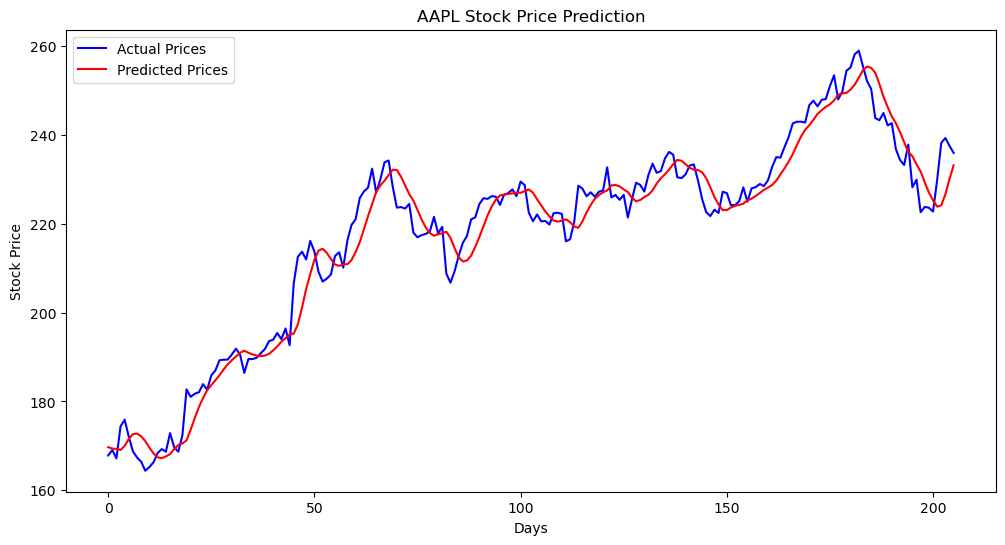

In [7]:
# Make predictions
predictions = model.predict(X_test)

# Reverse normalization
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
